# Hetroscodastic Gaussian Processes

Vanilla GP work under the assumption that noise observed in the data ($\mathcal{D}:\{\mathbf{X}, \mathbf{Y}\}$) is uniform and is not dependent on the inputs $\mathbf{X}$. Though such GPs can be used for learning to predict  $y_i$, they tend to over estimate the uncertanity associated with the prediction. 


In [1]:
import GPy
import copy
import numpy as np
import matplotlib.pyplot as plt

#### Matplotlib Configuration

In [2]:
plt.style.use('dark_background')
plt.rcParams["figure.figsize"] = (12,7)
plt.rcParams['axes.linewidth'] = 1.0
plt.rcParams['lines.linewidth'] = 4.0
plt.rcParams['font.size'] = 18.0
plt.rcParams['font.sans-serif'] = 'Helvetica'

The following synthetic example illustrates how hetroscodastic Gaussian Processes can be used to learn the input dependent noise.

### Synth Data 
$$f(x) = 4.0 \times \sin(2 \pi \times x) + \mathcal{N}(0.0, r(x))$$
$$r(x) = x$$

From above, it can be cleary noticed that noise in $f(x)$ is directly dependent on $x$

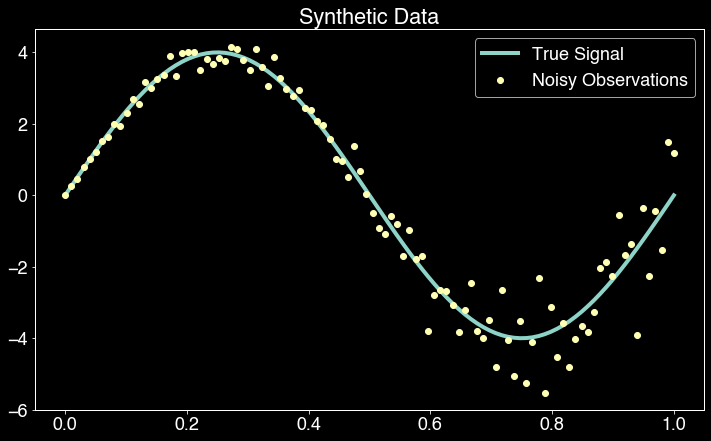

In [3]:
x  = np.linspace(0, 1, 100)
fx = 4.0*np.sin(2.0*np.pi*x)

y = np.zeros(len(x))
for idx,i in enumerate(x):
    y[idx] = 4.0*np.sin(2.0*np.pi*i) + np.random.normal(0.0, i+0.0)

plt.plot(x, fx, label="True Signal")
plt.plot(x, y, 'o', label="Noisy Observations")
plt.title("Synthetic Data")
plt.legend()

Before we dive into hetroscodastic GP, let look at how vanilla GP perform on this data.

## Vanilla Gaussian Processes

Optimization restart 1/5, f = 114.22298123464867
Optimization restart 2/5, f = 114.22298123540216
Optimization restart 3/5, f = 114.22298123462924
Optimization restart 4/5, f = 114.22298123466031
Optimization restart 5/5, f = 114.22298123465035


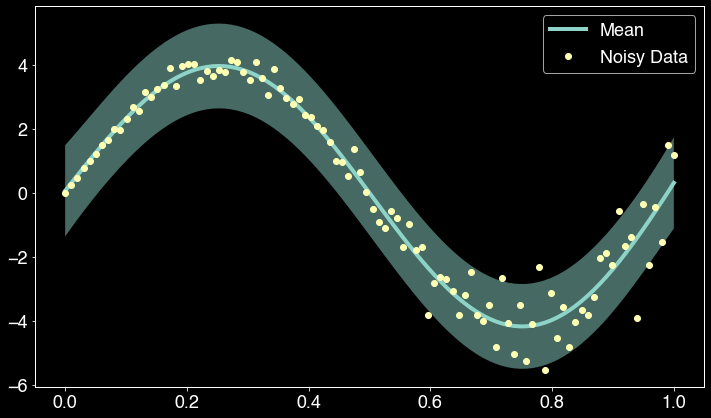

In [5]:
kernel_vgp = GPy.kern.RBF(input_dim=1) + GPy.kern.White(input_dim=1)
vgp = GPy.models.GPRegression(x.reshape(-1,1), y.reshape(-1,1), kernel_vgp)
vgp.optimize(messages=False)
vgp.optimize_restarts(num_restarts = 5)
# Plot error bounds
m, v = vgp.predict(x.reshape(-1,1))
up = m.reshape(-1) + 2.0*np.sqrt(v.reshape(-1))
dwn = m.reshape(-1) - 2.0*np.sqrt(v.reshape(-1))

plt.fill_between(x, up, dwn, alpha=0.5)
plt.plot(x, m, label="Mean")
plt.plot(x, y, 'o', label="Noisy Data")
plt.legend()
plt.savefig("sine_vgp.png")

We can clearly see that the variance is clearly overestimated. Now lets see how the hetroscodastic GPs fare

## Hetrosocastic Gaussian Processes

### Algorithm
* **Step-1:** Use the noisy input data $\mathcal{D}$ to learn a vanilla GP (GP1) that maximizes the likelyhood for predicting $y_i$ from $x_i$
* **Step-2:** Given GP1, estimate the emperical noise ($z`$) from the training data
$$z`_i = \log(var[y_i, GP1(x_i|\mathcal{D})])$$ 
and create a new data set $\mathcal{D}` = \{ (x_0, z`_0) \ldots (x_n, z`_n)\}$
* **Step-3:** Using $\mathcal{D}`$, learn GP2 to estimate noise ($z`$) from ($x$)
* **Step-4:** Now, using GP2 to estimate logarithmic noise, we train a combined GP3.
* **Step-5:** If not converged, GP1=GP3 and go to step 2

### Step-1 

$$ \mathcal{GP}1 : \mathbf{X} \rightarrow \mathbf{Y}$$

In [6]:
# RBF and WhiteNoise kernel
kernel1 = GPy.kern.RBF(input_dim=1) + GPy.kern.White(input_dim=1)
gp1 = GPy.models.GPRegression(x.reshape(-1,1),y.reshape(-1,1),kernel1)
gp1.optimize(messages=False)
gp1.optimize_restarts(num_restarts = 5)

Optimization restart 1/5, f = 114.22298123464867
Optimization restart 2/5, f = 114.2229812355149
Optimization restart 3/5, f = 114.22298123465013
Optimization restart 4/5, f = 114.22298123464978
Optimization restart 5/5, f = 114.22298123488116


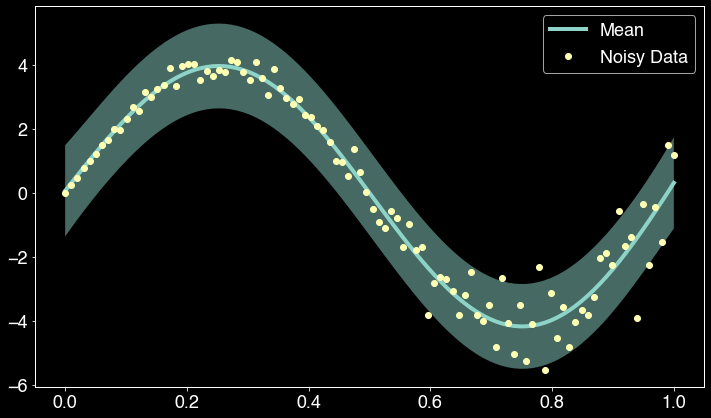

In [7]:
m, v = gp1.predict(x.reshape(-1,1))
up = m.reshape(-1) + 2.0*np.sqrt(v.reshape(-1))
dwn = m.reshape(-1) - 2.0*np.sqrt(v.reshape(-1))

plt.fill_between(x, up, dwn, alpha=0.5)
plt.plot(x, m, label="Mean")
plt.plot(x, y, 'o', label="Noisy Data")
plt.legend()

### Step-2
$$var[y_i, GP1(x_i|\mathcal{D})] = s^-1 \sum^s 0.5 \times (y_i - \mathcal{N}(\mu(x_i), \sigma(x_i))^2$$
Use this estimated variance for learning noise level in the data set.
$$z`_i = \log(var[y_i, GP1(x_i|\mathcal{D})])$$ 

In [13]:
m, v = gp1.predict(x.reshape(-1,1))
s = 10
variance_noise = np.zeros(len(x))
for j in range(0, len(x)):
    var = 0.0
    for i in range(0, s):
        var += 0.5 * (y[j] - np.random.normal(m[j], v[j]))**2
    variance_noise[j] = var/s
z = np.log(variance_noise)

### Step-3
$$ \mathcal{GP}2 : \mathbf{X} \rightarrow \mathbf{Z}`$$

In [14]:
kernel2 = GPy.kern.RBF(input_dim=1) + GPy.kern.White(input_dim=1)
gp2 = GPy.models.GPRegression(x.reshape(-1,1),z.reshape(-1,1),kernel2)
gp2.optimize(messages=False)
gp2.optimize_restarts(num_restarts = 10)
m_n, v_n = gp2.predict(x.reshape(-1,1))

Optimization restart 1/10, f = 159.05256965258576
Optimization restart 2/10, f = 159.05256965945642
Optimization restart 3/10, f = 159.0525696522383
Optimization restart 4/10, f = 159.0525696522793
Optimization restart 5/10, f = 159.05256968796374
Optimization restart 6/10, f = 159.05256965232576
Optimization restart 7/10, f = 159.05256965220798
Optimization restart 8/10, f = 159.05256965569555
Optimization restart 9/10, f = 159.05256965223217
Optimization restart 10/10, f = 159.05256965229117


### Step 4

$$r_i = e^{(\mu_{GP2}(x_i))}$$

Where $r_i$ is the estimated noise in the data. These estimates are used to populate the diagonal elements in the White Kernel. Which form the variance estimates for each data point.

In [15]:
kernel3 = GPy.kern.RBF(input_dim=1) + GPy.kern.WhiteHeteroscedastic(input_dim=1, num_data=x.shape[0])
gp3 = GPy.models.GPRegression(x.reshape(-1,1),y.reshape(-1,1),kernel3)
gp3.optimize(messages=False)
gp3.optimize_restarts(num_restarts = 10)
kernel3.parts[1].variance = np.exp(m_n).reshape(x.shape[0])

Optimization restart 1/10, f = -3.9937056553584753
Optimization restart 2/10, f = 5.75204470264552
Optimization restart 3/10, f = -6.985282605633202
Optimization restart 4/10, f = -2.573332080158778
Optimization restart 5/10, f = -4.706184923477295
Optimization restart 6/10, f = 2.4980392042929154
Optimization restart 7/10, f = 6.1818739000623
Optimization restart 8/10, f = 3.063100769230786
Optimization restart 9/10, f = -3.1090390663292737
Optimization restart 10/10, f = -6.406221714564914


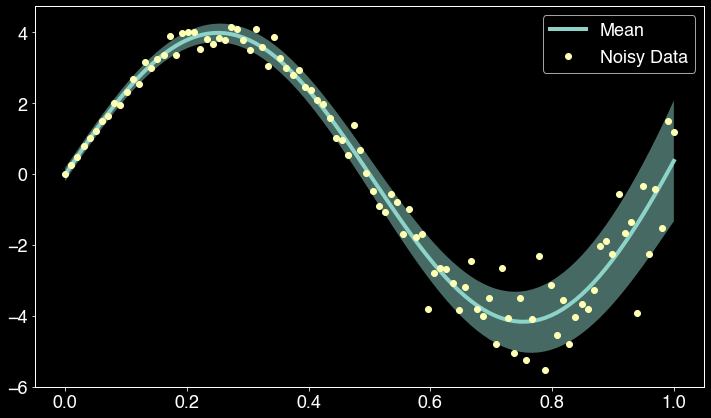

In [17]:
m, v = gp3.predict(x.reshape(-1,1))
up = m.reshape(-1) + 2.0*np.sqrt(v.reshape(-1))
dwn = m.reshape(-1) - 2.0*np.sqrt(v.reshape(-1))
plt.fill_between(x, up, dwn, alpha=0.5)
plt.plot(x, m, label="Mean")
plt.plot(x, y, 'o', label="Noisy Data")
plt.legend()
plt.savefig("sine_hgp.png")

### Step 5

In [12]:
gp1 = copy.deepcopy(gp3)

## Validation

Lets compare the variance estimated by the GPs to the variance injected into the data.

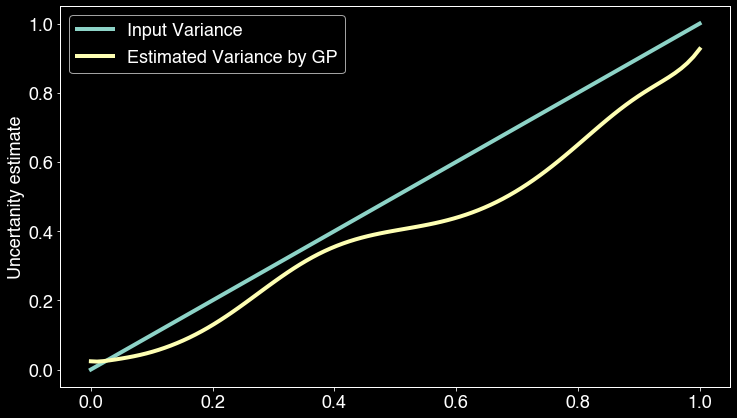

In [34]:
plt.plot(x, x, label="Input Variance")
plt.plot(x, 2.0*np.sqrt(v), label="Estimated Variance by GP")
plt.ylabel("Uncertanity estimate")
plt.legend()

That is pretty close!!

### Things to address before moving on to next phase.

**Things to figure out**
1. How to measure convergence between GP3 and GP1?
    - One way would be to see the difference in the variance estimates.
    $$ Var = ||v_i - v_{i+1}||^2 $$
    $$ Var < 10^{-3} $$
2. Find a better way to handle WhiteHetroscodastic Kernel and its optimize call.

These will be addressed in the next notebook. Until then adieu.